# Data Analysis

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
from data import get_data, extract_date_data
from utils import get_path, load_model_data, month, day_of_week, precip_type
from sklearn.model_selection import ShuffleSplit
from skgarden import ExtraTreesQuantileRegressor
from tqdm.auto import tqdm
plt.style.use('ggplot')

/home/leidem/gitsky/streetwise-model/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/leidem/gitsky/streetwise-model/venv/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/leidem/gitsky/streetwise-model/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed 

## Feature selection

We start by loading in the weather features and choosing a (roughly) independent subset of these to use for training our model.

In [2]:
weather_df = pd.read_csv(get_path('data') / 'weather_data.tsv', sep = '\t')
weather_df['precip_type'] = weather_df['precip_type'].map(precip_type)
weather_df.head()

,date,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity
0,2018-02-03,0.1336,0.0190,1,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83
1,2018-02-04,0.0129,0.0005,1,7.07,7.05,11.88,7.28,-3.10,-0.07,-1.50,-0.20,-3.27,0.76
2,2018-02-05,0.0000,0.0000,0,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74
3,2018-02-06,0.0000,0.0000,0,5.84,5.86,6.98,5.88,-5.55,-2.78,-4.15,-2.78,-5.11,0.74
4,2018-02-07,0.0000,0.0000,0,3.62,3.65,5.26,3.74,-5.11,-0.01,-2.72,-0.01,-2.83,0.68


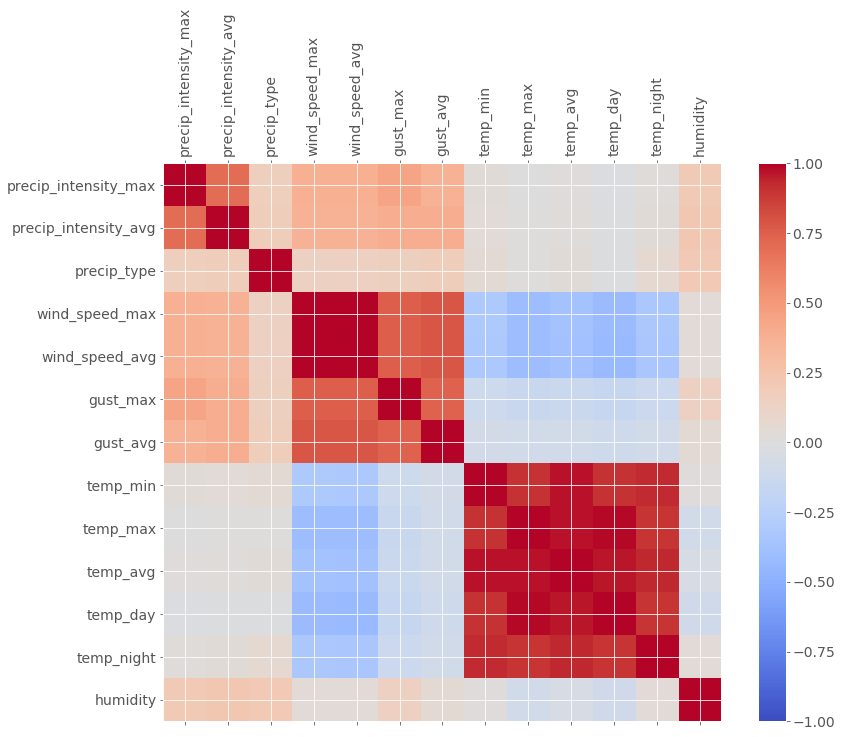

In [3]:
feat_df = weather_df.copy()[[col for col in list(weather_df.columns) if col not in ['date']]]
f = plt.figure(figsize = (13, 10))
plt.matshow(feat_df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(feat_df.shape[1]), feat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(feat_df.shape[1]), feat_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

As we can see on the above heatmap, our weather features are highly dependent, so we *do* need to trim these down a bit.

We see that the majority of the dependencies cluster in three groups: precipitation, wind speed / gusts, and temperature. We therefore start by only including the average values of these three groups, as we hypothesise that these averages will be more reliable when we fetch forecasts for our predictions.

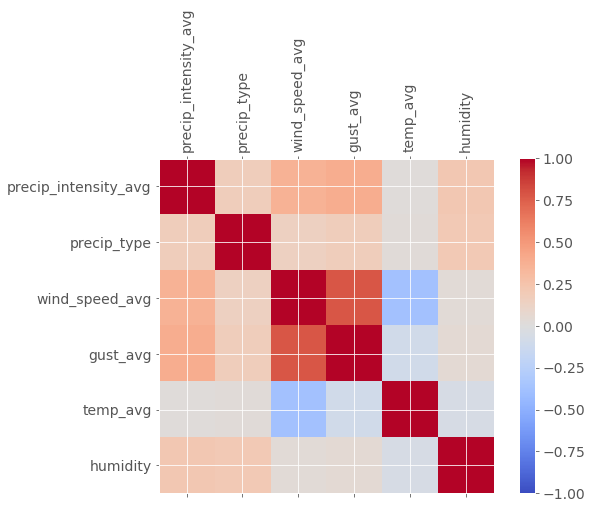

In [4]:
features = ['precip_intensity_avg', 'precip_type', 'wind_speed_avg', 'gust_avg', 'temp_avg', 'humidity']
trimmed_feat_df = weather_df.copy()[features]
f = plt.figure(figsize = (9, 6))
plt.matshow(trimmed_feat_df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(trimmed_feat_df.shape[1]), trimmed_feat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(trimmed_feat_df.shape[1]), trimmed_feat_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

The major dependency remaining is between wind speed average and gust average, so we remove the gust average.

This is again because we hypothesise that wind speeds are easier to forecast.

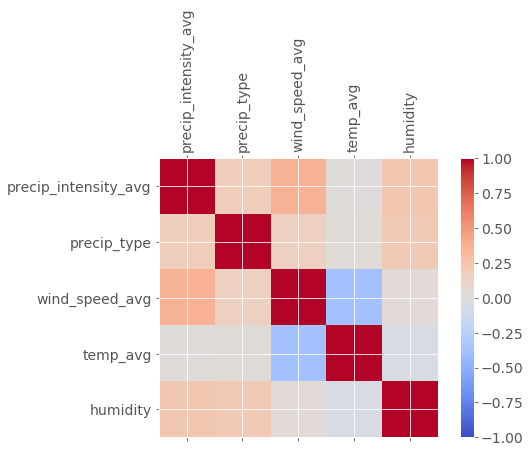

In [5]:
features = ['precip_intensity_avg', 'precip_type', 'wind_speed_avg', 'temp_avg', 'humidity']
final_feat_df = weather_df.copy()[features]
f = plt.figure(figsize = (8, 5))
plt.matshow(final_feat_df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(final_feat_df.shape[1]), final_feat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(final_feat_df.shape[1]), final_feat_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

This looks good! We'll also be using some date-related features: `month`, `day_of_month` and `day_of_week`.

Let's load in our training dataset with all these features.

In [6]:
X, y = get_data(include_date = True)
df = X.copy()
X.drop(columns = ['date'], inplace = True)
df['total'] = y.copy()
df.head()

,date,year,month,day_of_week,day_of_month,precip_intensity_avg,precip_type,wind_speed_avg,temp_avg,humidity,total
0,2018-02-03,2018.0,2.0,6.0,3.0,0.0190,1.0,3.25,1.58,0.83,34.0
1,2018-02-04,2018.0,2.0,7.0,4.0,0.0005,1.0,7.05,-1.50,0.76,65.0
2,2018-02-05,2018.0,2.0,1.0,5.0,0.0000,0.0,7.74,-2.71,0.74,52.0
3,2018-02-07,2018.0,2.0,3.0,7.0,0.0000,0.0,3.65,-2.72,0.68,50.5
4,2018-02-08,2018.0,2.0,4.0,8.0,0.0014,2.0,4.45,-0.87,0.74,25.0


## Analysis of target labels

In [7]:
def earlier_than(date1: str, date2: str):
    from datetime import datetime
    date1, date2 = datetime.strptime(date1, '%Y-%m-%d'), datetime.strptime(date2, '%Y-%m-%d')
    return date1 < date2

Now that we've chosen our features, let's have a look at what we're trying to predict.

Here's a plot of the reported total demand for a Bristol Soup Run Trust (BSRT) over time.

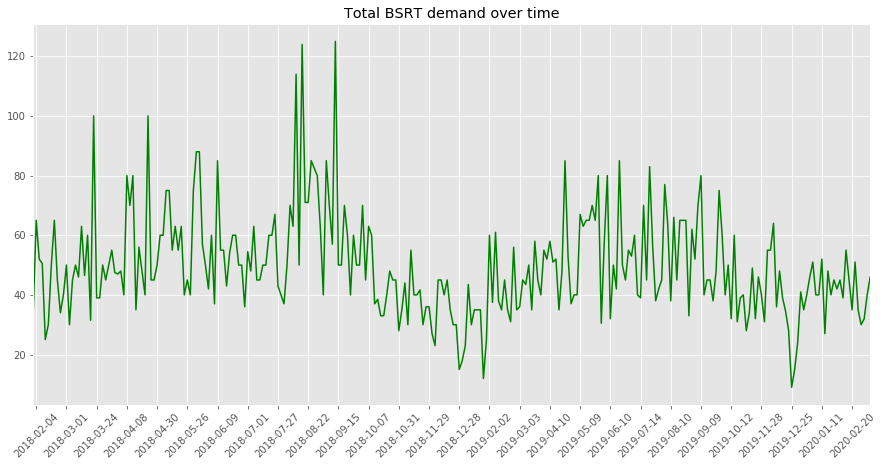

In [8]:
xticks = list(range(1, len(df.index), 10))
ax = df.total.plot(figsize = (15, 7), title = 'Total BSRT demand over time', 
                   rot = 45, xticks = xticks, color = 'g')
ax.set_xticklabels(df.date[xticks])
plt.show()

We also see that these values approximately follow a normal distribution, as can be seen on the following histogram.

In [9]:
train_idxs = [idx for idx, date in zip(df.index, df.date) if earlier_than(date, '2019-11-04')]
X_train, X_val = X.iloc[train_idxs, :], X.iloc[list(set(df.index) - set(train_idxs)), :]
y_train, y_val = y[train_idxs], y[list(set(df.index) - set(train_idxs))]
X_train.head()

,year,month,day_of_week,day_of_month,precip_intensity_avg,precip_type,wind_speed_avg,temp_avg,humidity
0,2018.0,2.0,6.0,3.0,0.0190,1.0,3.25,1.58,0.83
1,2018.0,2.0,7.0,4.0,0.0005,1.0,7.05,-1.50,0.76
2,2018.0,2.0,1.0,5.0,0.0000,0.0,7.74,-2.71,0.74
3,2018.0,2.0,3.0,7.0,0.0000,0.0,3.65,-2.72,0.68
4,2018.0,2.0,4.0,8.0,0.0014,2.0,4.45,-0.87,0.74


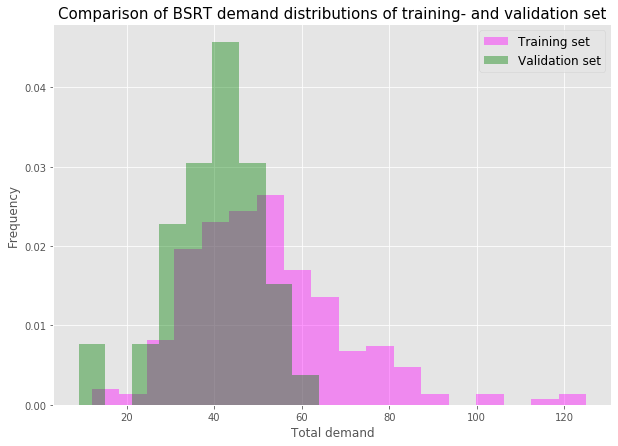

In [10]:
plt.figure(figsize = (10,7))

plt.hist(y_train, bins='auto', alpha=0.4, density = True, color='magenta', 
         label = 'Training set')
plt.hist(y_val, bins='auto', alpha=0.4, density = True, color='green', 
         label = 'Validation set')

plt.title('Comparison of BSRT demand distributions of training- and validation set', fontsize = 15)
plt.xlabel('Total demand')
plt.ylabel('Frequency')
plt.legend(fontsize = 12)
plt.show()

## Model selection

We fitted a wide variety of models to the data, and we found that forest-based estimators performed the best in terms of mean absolute error (MAE). Further, we refined this by choosing a forest of `ExtraTrees`, which also performs the splittings in the individual trees at random, reducing variance.

We performed a Bayesian hyperparameter search for 150 iterations over all the parameters in the forest, and found that the only parameter that resulted in better performance over the default values were the number of trees, which we increased from 100 to 3000.

In [11]:
model = load_model_data()['model'].fit(X, y)
model

ExtraTreesQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
                            max_features='auto', max_leaf_nodes=None,
                            min_samples_leaf=3, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=1000,
                            n_jobs=-1, oob_score=False, random_state=None,
                            verbose=0, warm_start=False)

Before we start evaluating the model, we can see which features that the model found the most important for the splittings in the trees.

In [12]:
sorted(zip(model.fit(X, y).feature_importances_, X.columns), reverse = True)

[(0.26469680304466403, 'month'),
 (0.19872188994179166, 'temp_avg'),
 (0.1336149877635219, 'day_of_week'),
 (0.1003795294340879, 'day_of_month'),
 (0.07678617186452921, 'wind_speed_avg'),
 (0.07534794804754957, 'humidity'),
 (0.06835536035111413, 'year'),
 (0.04379954882708635, 'precip_intensity_avg'),
 (0.03829776072565516, 'precip_type')]

## Evaluating the model

We first check whether the distribution of the predicted values follow the same distribution as the actual target values.

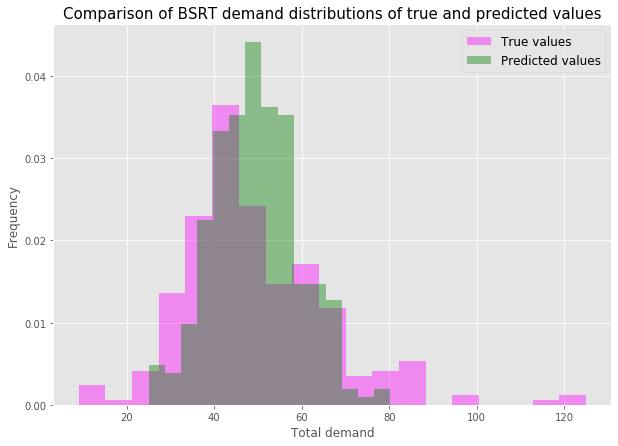

In [13]:
plt.figure(figsize = (10,7))
plt.hist(y, bins='auto', alpha=0.4, density = True, color='magenta', 
         label = 'True values')
plt.hist(model.predict(X), bins='auto', alpha=0.4, density = True, color='green', 
         label = 'Predicted values')

plt.title('Comparison of BSRT demand distributions of true and predicted values', fontsize = 15)
plt.xlabel('Total demand')
plt.ylabel('Frequency')
plt.legend(fontsize = 12)
plt.show()

We see that they are quite similar. As a preliminary evaluation of the model's performance, we define a function that trains the model up to a certain date and evaluates it on the remaining data points.

In [14]:
alphas = [.75, .90, .95]
opacities = np.linspace(0.1, 0.3, len(alphas))

In [15]:
def viz_model(cutoff_date = '2019-11-04'):
    train_idxs = [idx for idx, date in zip(df.index, df.date) if earlier_than(date, cutoff_date)]

    print(f'Number of training samples: {len(train_idxs)}')
    print(f'Number of validation samples: {len(df) - len(train_idxs)}')

    X_train, X_val = X.iloc[train_idxs, :], X.iloc[list(set(df.index) - set(train_idxs)), :]
    y_train, y_val = y[train_idxs], y[list(set(df.index) - set(train_idxs))]
    idxs = sorted(X_val.index)

    fig, ax = plt.subplots(figsize = (15, 7))
    plt.scatter(df.date[idxs], df.total[idxs], marker = 'x', label = 'True values', color = 'green')

    model.fit(X_train, y_train)
    
    #plt.plot(df.date[idxs], model.predict(X_val), color = 'black', label = 'Predictions')
    preds = model.predict(X_val)
    errs = np.zeros((2, len(idxs)))
    errs[0, :] = np.maximum(0, preds - df.total[idxs])
    errs[1, :] = np.maximum(0, df.total[idxs] - preds)
    plt.errorbar(df.date[idxs], preds, yerr = errs, color = 'black', linewidth = 0, 
                 elinewidth = 1, label = 'Prediction errors')

    for idx, alpha in enumerate(alphas):
        lower = model.predict(X_val, 100 * (1 - alpha) / 2)
        upper = model.predict(X_val, 100 * (1 + alpha) / 2)
        plt.fill_between(df.date[idxs], lower, upper, figure = fig, color = 'purple', 
                         alpha = opacities[-(idx + 1)], label = f'{round(100 * alpha, 1)}% prediction interval')

        coverage = sum((df.total[idxs] > lower) & (df.total[idxs] < upper)) / len(df.total[idxs])
        print(f'Coverage for the {100 * alpha:.1f}% prediction interval: {100 * coverage:.1f}%')

    plt.legend(fontsize = 10)
    plt.xticks(rotation = 90)
    plt.title(type(model).__name__, fontsize = 18)  

    plt.show()

Number of training samples: 235
Number of validation samples: 43
Coverage for the 75.0% prediction interval: 67.4%
Coverage for the 90.0% prediction interval: 88.4%
Coverage for the 95.0% prediction interval: 93.0%


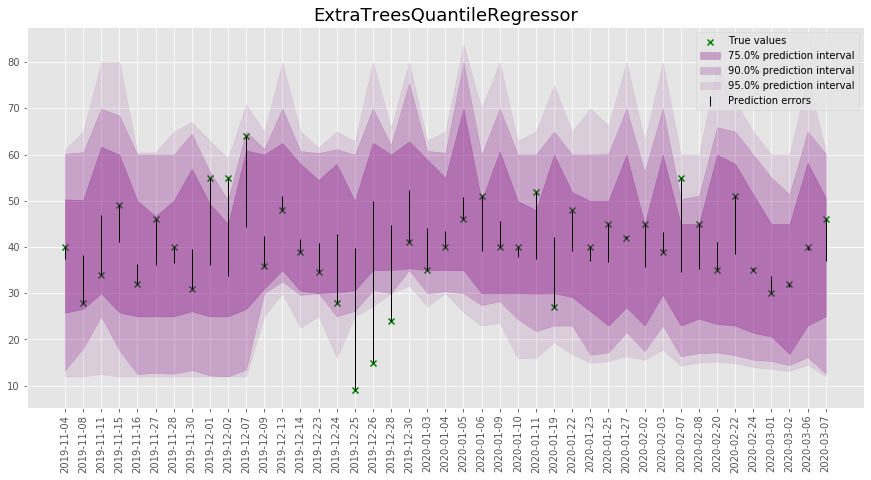

In [16]:
viz_model(cutoff_date = '2019-11-04')

We see that the coverages are quite reasonable! Note that the model will be more accurate when we train it on more data, rather than only up to the above cut-off point. Below we do a bit more serious testing: we perform 10 random train-test splits of the data with 10% test data, and evaluate various stats and their aggregates.

In [17]:
ss = ShuffleSplit(n_splits = 10, test_size = 0.1)
pbar = tqdm(ss.split(np.arange(X.shape[0])), desc = 'Evaluating', total = ss.n_splits)

maes, covs, offs = np.empty(ss.n_splits), np.empty(ss.n_splits), np.empty(ss.n_splits)
lens, uppers = np.empty(ss.n_splits), np.empty(ss.n_splits)
for idx, (train_idxs, test_idxs) in enumerate(pbar):
    
    X_train, X_test = X.values[train_idxs, :], X.values[test_idxs]
    y_train, y_test = y.values[train_idxs], y.values[test_idxs]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    upper = model.predict(X_test, 97.5)
    lower = model.predict(X_test, 2.5)
    
    below_upper = y_test <= upper
    above_lower = y_test >= lower
    coverage = np.mean(below_upper & above_lower)

    above_errs = y_test[~below_upper] - upper[~below_upper]
    above_err = above_errs.mean() if above_errs.size else 0
    below_errs = lower[~above_lower] - y_test[~above_lower]
    below_err = below_errs.mean() if below_errs.size else 0
    
    covs[idx] = np.mean((y_test < upper) & (y_test > lower))
    lens[idx] = np.mean(upper - lower)
    uppers[idx] = upper.mean()
    maes[idx] = np.abs(preds - y_test).mean()
    offs[idx] = (above_err + below_err) / 2
    
print(f'Mean absolute errors: {np.around(maes, 2)}')
print(f'\t- Average: {maes.mean():.2f}')
print(f'\t- Standard deviation: {maes.std():.2f}')

print(f'\nCoverages: {np.around(covs, 2)}')
print(f'\t- Average: {covs.mean():.2f}')
print(f'\t- Standard deviation: {covs.std():.2f}')

print(f'\nLengths: {np.around(lens, 2)}')
print(f'\t- Average: {lens.mean():.2f}')
print(f'\t- Standard deviation: {lens.std():.2f}')

print(f'\nUpper interval bounds: {np.around(uppers, 2)}')
print(f'\t- Average: {uppers.mean():.2f}')
print(f'\t- Standard deviation: {uppers.std():.2f}')

print(f'\nOff values: {np.around(offs, 2)}')
print(f'\t- Average: {offs.mean():.2f}')
print(f'\t- Standard deviation: {offs.std():.2f}')


Mean absolute errors: [ 9.62 11.31 11.34 13.63  9.88 14.07 10.02 12.32 10.99 12.21]
	- Average: 11.54
	- Standard deviation: 1.45

Coverages: [0.96 0.89 0.96 0.96 0.93 0.82 0.96 0.89 0.96 0.96]
	- Average: 0.93
	- Standard deviation: 0.05

Lengths: [53.62 57.02 59.03 53.38 57.36 54.65 56.4  52.75 56.84 63.67]
	- Average: 56.47
	- Standard deviation: 3.07

Upper interval bounds: [81.96 87.29 88.63 80.78 84.34 82.2  86.31 78.69 84.48 91.02]
	- Average: 84.57
	- Standard deviation: 3.61

Off values: [ 2.5   3.    0.   17.5   7.    7.28  0.    7.01  0.    6.  ]
	- Average: 5.03
	- Standard deviation: 5.06


We see here that the average coverage is spot on and the average mean absolute error is somewhat reasonable. The intervals are still quite wide, but with more data they will hopefully become narrower.

## Using the model to impute data

Fitting the model on all the data, we can then use the predictions to impute all the missing data we have on all the days where nothing was reported. We have weather data for all the dates in `weather_df`, so we just need to extract the date features and merge them.

In [18]:
dates = weather_df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
date_df = extract_date_data(dates)
date_df.head()

,year,month,day_of_week,day_of_month
0,2018,february,saturday,3
1,2018,february,sunday,4
2,2018,february,monday,5
3,2018,february,tuesday,6
4,2018,february,wednesday,7


In [19]:
feat_df = pd.concat([date_df, weather_df[['date'] + features]], axis = 1)
feat_df.head()

,year,month,day_of_week,day_of_month,date,precip_intensity_avg,precip_type,wind_speed_avg,temp_avg,humidity
0,2018,february,saturday,3,2018-02-03,0.0190,1,3.25,1.58,0.83
1,2018,february,sunday,4,2018-02-04,0.0005,1,7.05,-1.50,0.76
2,2018,february,monday,5,2018-02-05,0.0000,0,7.74,-2.71,0.74
3,2018,february,tuesday,6,2018-02-06,0.0000,0,5.86,-4.15,0.74
4,2018,february,wednesday,7,2018-02-07,0.0000,0,3.65,-2.72,0.68


In [20]:
feat_df['month'] = feat_df['month'].map(month)
feat_df['day_of_week'] = feat_df['day_of_week'].map(day_of_week)
feat_df.head()

,year,month,day_of_week,day_of_month,date,precip_intensity_avg,precip_type,wind_speed_avg,temp_avg,humidity
0,2018,2,6,3,2018-02-03,0.0190,1,3.25,1.58,0.83
1,2018,2,7,4,2018-02-04,0.0005,1,7.05,-1.50,0.76
2,2018,2,1,5,2018-02-05,0.0000,0,7.74,-2.71,0.74
3,2018,2,2,6,2018-02-06,0.0000,0,5.86,-4.15,0.74
4,2018,2,3,7,2018-02-07,0.0000,0,3.65,-2.72,0.68


We next load our model and perform all the predictions for the missing values.

In [21]:
pred_df = feat_df.copy()
for alpha in alphas:
    preds = model.predict(feat_df.drop(columns = ['date']))
    lower = model.predict(feat_df.drop(columns = ['date']), 100 * (1 - alpha) / 2)
    upper = model.predict(feat_df.drop(columns = ['date']), 100 * (1 + alpha) / 2)
    pred_df['prediction'] = preds
    pred_df[round(100 * (1 - alpha) / 2, 1)] = lower
    pred_df[round(100 * (1 + alpha) / 2, 1)] = upper
pred_df.head()

,year,month,day_of_week,day_of_month,date,precip_intensity_avg,precip_type,wind_speed_avg,temp_avg,humidity,prediction,12.5,87.5,5.0,95.0,2.5,97.5
0,2018,2,6,3,2018-02-03,0.0190,1,3.25,1.58,0.83,43.649853,31.146898,60.000000,30.000000,65.000000,24.980332,67.562267
1,2018,2,7,4,2018-02-04,0.0005,1,7.05,-1.50,0.76,49.293568,33.024996,64.963725,30.000000,69.358302,25.431307,80.000000
2,2018,2,1,5,2018-02-05,0.0000,0,7.74,-2.71,0.74,48.992358,34.582623,62.347249,30.000000,70.000000,26.830451,75.000000
3,2018,2,2,6,2018-02-06,0.0000,0,5.86,-4.15,0.74,47.817817,31.049947,61.646660,26.771431,68.747724,24.839708,76.701923
4,2018,2,3,7,2018-02-07,0.0000,0,3.65,-2.72,0.68,46.933463,30.000000,60.000000,25.892022,66.312479,24.695751,76.488435


Using these predictions, let's predict the imputed values.

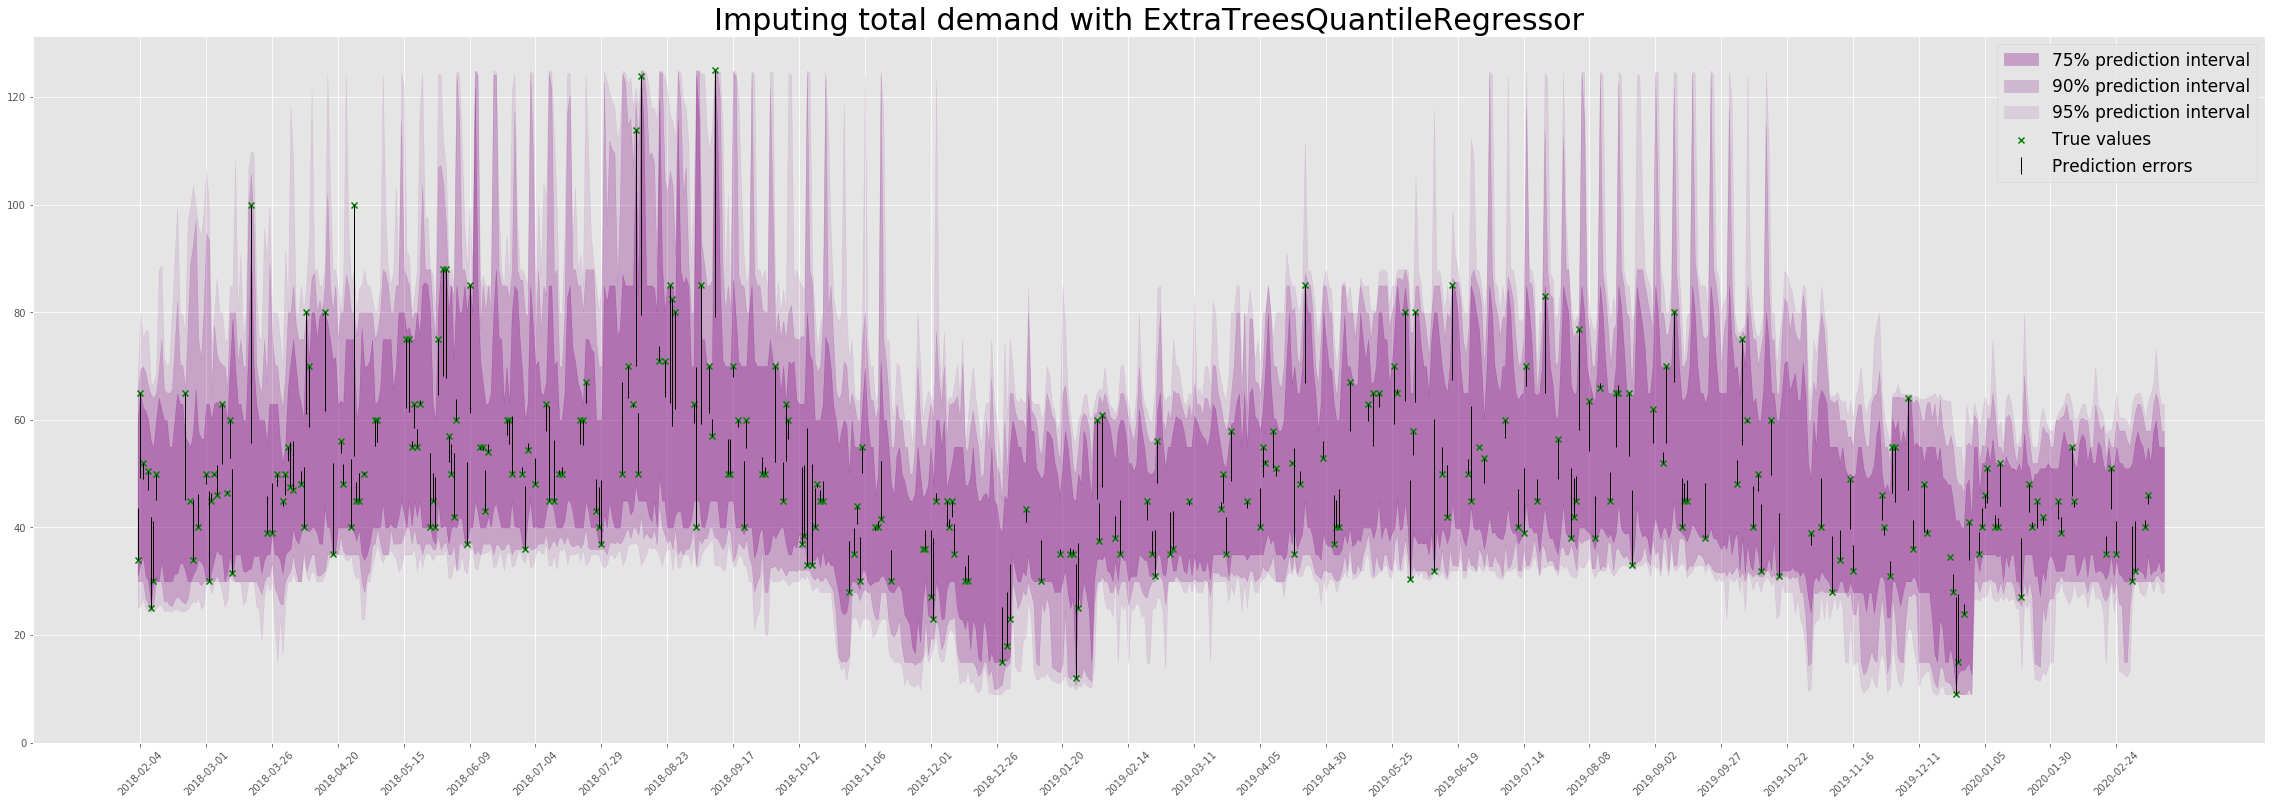

In [22]:
fig = plt.figure(figsize = (40, 13))

for idx, alpha in enumerate(alphas):
    plt.fill_between(pred_df.date, 
                     pred_df[round(100 * (1 - alpha) / 2, 1)], 
                     pred_df[round(100 * (1 + alpha) / 2, 1)],
                     figure = fig, 
                     color = 'purple', 
                     alpha = opacities[-(idx + 1)],
                     label = f'{int(round(alpha * 100))}% prediction interval'
                     )
plt.scatter(df.date, df.total, color = 'green', marker = 'x', label = 'True values')

#plt.plot(pred_df.date, pred_df.prediction, color = 'black')

totals = pred_df.prediction.copy()
totals[pred_df.date.isin(df.date)] = df.total.values
yerr = np.zeros((2, totals.shape[0]))
yerr[0, :] = np.maximum(0, pred_df.prediction - totals)
yerr[1, :] = np.maximum(0, totals - pred_df.prediction)
plt.errorbar(pred_df.date, pred_df.prediction, yerr = yerr, color = 'black', linewidth = 0, 
             elinewidth = 1, label = 'Prediction errors')

plt.xticks(range(1, len(pred_df.index), 25), 
           pred_df.date[list(range(1, len(pred_df.index), 25))], 
           rotation = 45)
plt.legend(fontsize = 17)
plt.ylim(bottom = 0)
plt.title(f'Imputing total demand with {type(model).__name__}', fontsize = 30)
plt.show()

We see that the intervals capture most of the values, which should also be the case as those are the values that we trained the model on!